# Tutorial 2 - KERAS DNN Regression

We will predict the price of an AIRBNB listing (`price` column). This is a regression task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

# Data Prep

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [5]:
# We can't use the following columns in this tutorial

train = train_set.drop(['price_category', 'price_gte_150'], axis=1)
test = test_set.drop(['price_category', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [6]:
train_target = train[['price']]
test_target = test[['price']]

train_inputs = train.drop(['price'], axis=1)
test_inputs = test.drop(['price'], axis=1)

## Feature Engineering: Let's derive a new column

#### Remember, the "minimum_nights" column is highly skewed. Let's try to transform it. 

In [7]:
train_inputs['minimum_nights'].value_counts()

1      1017
2       666
3       443
4        88
7        82
5        58
10       45
30       18
14       16
15       14
6        12
28        6
20        5
32        3
60        3
9         2
18        1
13        1
8         1
273       1
11        1
21        1
90        1
23        1
17        1
25        1
Name: minimum_nights, dtype: int64

<Axes: >

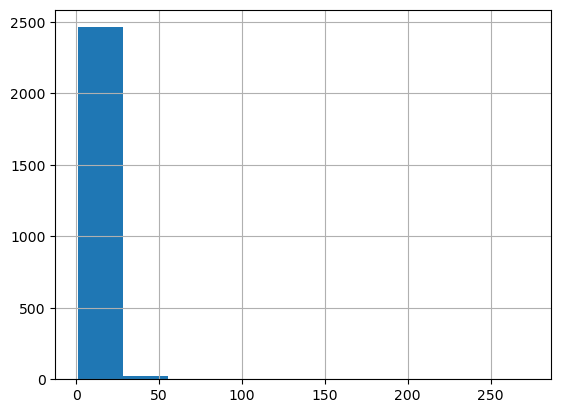

In [8]:
train_inputs['minimum_nights'].hist()

In [9]:
# Import power transformer from sklearn. It will help us create a "normal distribution"
from sklearn.preprocessing import QuantileTransformer

QT = QuantileTransformer(output_distribution='uniform')

In [10]:
transformed_min_nights = QT.fit_transform(train_inputs[['minimum_nights']])

array([[<Axes: title={'center': '0'}>]], dtype=object)

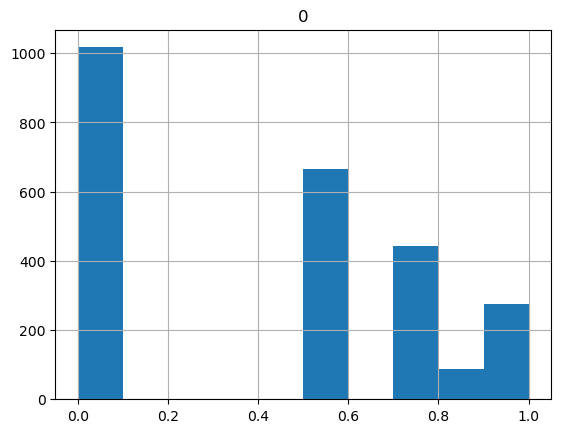

In [11]:
pd.DataFrame(transformed_min_nights).hist()

NOTE1: We didn't make the transformed variable as part of the input variables yet. To do that, we will use the pipeline.

NOTE2: We don't need to create a function (like before). This transformer already has fit() and transform(). So, we can use this in the pipeline.

##  Identify the numerical and categorical columns

In [12]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [13]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [14]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [15]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [16]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [17]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [18]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [19]:
transformed_columns = ['minimum_nights']

# Pipeline

In [20]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [21]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [23]:
my_new_column = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('quantiletransformer', QuantileTransformer(output_distribution='uniform'))])

In [24]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, transformed_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [25]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.82254842,  0.69215829,  0.54753414, ...,  1.        ,
         1.        ,  0.54254254],
       [ 0.55146572,  0.15729058,  0.54753414, ...,  0.        ,
         1.        ,  0.54254254],
       [ 0.07311286, -1.97951247, -0.59100739, ...,  0.        ,
         0.        ,  0.9019019 ],
       ...,
       [-0.61093878, -0.07631528,  3.96315871, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.17819153, -0.94575177, -1.16027815, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33618088,  1.03587419, -0.59100739, ...,  0.        ,
         1.        ,  0.54254254]])

In [26]:
train_x.shape

(2488, 67)

# Tranform: transform() for TEST

In [27]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[-1.21269719, -1.20324989,  0.54753414, ...,  0.        ,
         1.        ,  0.54254254],
       [-2.86419979, -2.67831359, -0.59100739, ...,  0.        ,
         0.        ,  0.        ],
       [-0.11443035,  1.26295963, -0.59100739, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.47803436, -1.63486781, -0.59100739, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.59928397,  0.34795157,  2.82461719, ...,  0.        ,
         0.        ,  0.54254254],
       [ 0.19953968,  0.22845713, -0.59100739, ...,  0.        ,
         1.        ,  0.93443443]])

In [28]:
test_x.shape

(1067, 67)

## No transformation needed for the target variables

# Calculate the baseline

In [29]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(train_x, train_target)

DummyRegressor()

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
#Baseline Train RMSE
dummy_train_pred = dummy_regr.predict(train_x)

baseline_train_mse = mean_squared_error(train_target, dummy_train_pred)

baseline_train_rmse = np.sqrt(baseline_train_mse)

print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

Baseline Train RMSE: 103.84299127618122


In [32]:
#Baseline Test RMSE
dummy_test_pred = dummy_regr.predict(test_x)

baseline_test_mse = mean_squared_error (test_target, dummy_test_pred)

baseline_test_rmse = np.sqrt(baseline_test_mse)

print('Baseline Test RMSE: {}' .format(baseline_test_rmse))

Baseline Test RMSE: 102.31125032666752


# Train the model



In [33]:
import tensorflow as tf
from tensorflow import keras

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
#What is your input shape?
#(meaning: how many neurons should be in the input layer?)

train_x.shape

(2488, 67)

## Single Layer (Shallow) Network

In [36]:
#Define the model: for multi-class

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(67,)))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation=None))

#final layer: there has to be 1 node with no activation

In [37]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])

## Ordinal target (as in this example):

Final layer's activation = **softmax** <br>
loss = **sparse_categorical_crossentropy**

## One-hot target

Final layer's activation = **softmax** <br>
loss = **categorical_crossentropy**

## Binary target 

Final layer has only 1 neuron <br>
Final layer's activation = **sigmoid** <br>
loss = **binary_crossentropy**

## Regression task (target is continuous)

Final layer has only 1 neuron (keras.layers.Dense(1))<br>
Activation is None<br>
loss = **mean_squared_error**


In [38]:
# Fit the model

history = model.fit(train_x, train_target, 
                    validation_data=(test_x, test_target), 
                    epochs=20, batch_size=100)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 39151.1211 - mse: 39157.2695 - val_loss: 27791.9238 - val_mse: 28069.9883
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27977.5234 - mse: 27983.3984 - val_loss: 11745.3477 - val_mse: 11900.6572
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11408.8633 - mse: 11410.3799 - val_loss: 5427.8442 - val_mse: 5501.1807
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6091.6855 - mse: 6092.1670 - val_loss: 4835.1543 - val_mse: 4896.9219
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5433.7764 - mse: 5434.2920 - val_loss: 4438.1963 - val_mse: 4496.1704
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5097.6323 - mse: 5098.0464 - val_loss: 4237.6782 - val_mse: 4290.8433
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4833.6846 - mse: 4834.0620 - val_loss: 4082.4514 - val_mse: 4132.5713
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4658.7920 - mse: 4659.1255 - val_lo

In [39]:
# evaluate the model

train_scores = model.evaluate(train_x, train_target, verbose=0)

test_scores = model.evaluate(test_x, test_target, verbose=0)

In [40]:
# extract the TRAIN mse from model.evaluate

print("TRAIN:")

print("%s: %.2f" % (model.metrics_names[1], train_scores[1]))

#Calculate RMSE:
print("%s: %.2f" % ("RMSE", np.sqrt(train_scores[1])))


TRAIN:
compile_metrics: 3620.60
RMSE: 60.17


In [41]:
# extract the TEST mse from model.evaluate

print("TEST:")

print("%s: %.2f" % (model.metrics_names[1], test_scores[1]))

#Calculate RMSE:
print("%s: %.2f" % ("RMSE", np.sqrt(test_scores[1])))

TEST:
compile_metrics: 3617.31
RMSE: 60.14


#### IDK if the model above is underfitting lets use below wide and deep what values they produce

## Deep Network (Funnel architecture)

In [43]:
#Define the model: for multi-class

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(67,)))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(25, activation='relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1, activation=None))


#final layer: there has to be 1 node with no activation

In [44]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])

In [45]:
# Fit the model

history = model.fit(train_x, train_target, 
                    validation_data=(test_x, test_target), 
                    epochs=20, batch_size=100)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 37497.5469 - mse: 37506.9023 - val_loss: 6000.1934 - val_mse: 6078.4844
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7725.2500 - mse: 7726.4487 - val_loss: 4337.5737 - val_mse: 4392.1260
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4980.1641 - mse: 4980.6875 - val_loss: 3881.8813 - val_mse: 3930.0088
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4494.3535 - mse: 4494.6890 - val_loss: 3748.7256 - val_mse: 3789.1345
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4298.1079 - mse: 4298.3838 - val_loss: 3686.6116 - val_mse: 3723.4517
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4184.6328 - mse: 4184.8643 - val_loss: 3645.9922 - val_mse: 3680.2429
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4099.2080 - mse: 4099.4189 - val_loss: 3615.6482 - val_mse: 3648.4797
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4024.3560 - mse: 4024.5571 - val_loss: 3597

In [46]:
# evaluate the model

train_scores = model.evaluate(train_x, train_target, verbose=0)

test_scores = model.evaluate(test_x, test_target, verbose=0)

In [47]:
# extract the TRAIN mse from model.evaluate

print("TRAIN:")

print("%s: %.2f" % (model.metrics_names[1], train_scores[1]))

#Calculate RMSE:
print("%s: %.2f" % ("RMSE", np.sqrt(train_scores[1])))


TRAIN:
compile_metrics: 3059.76
RMSE: 55.32


In [48]:
# extract the TEST mse from model.evaluate

print("TEST:")

print("%s: %.2f" % (model.metrics_names[1], test_scores[1]))

#Calculate RMSE:
print("%s: %.2f" % ("RMSE", np.sqrt(test_scores[1])))

TEST:
compile_metrics: 3665.07
RMSE: 60.54


# Wide & Deep Network

## Let's send all inputs to the last layer

In [51]:
model = keras.models.Sequential()


inputlayer = keras.layers.Input(shape=(67,))

hidden1 = keras.layers.Dense(67, activation='relu')(inputlayer)
hidden2 = keras.layers.Dense(67, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(67, activation='relu')(hidden2)

concat = keras.layers.Concatenate()([inputlayer, hidden3])

#final layer: there has to be 1 node with no activation
output = keras.layers.Dense(1, activation=None)(concat)

model = keras.Model(inputs =[inputlayer], outputs = output)


In [52]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 67)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 67)        │      4,556 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 67)        │      4,556 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 67)        │      4,556 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 134)       │          0 │ input_layer_5[0]… │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        135 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,803 (53.92 KB)

 Trainable params: 13,803 (53.92 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])

In [54]:
# Fit the model

history = model.fit(train_x, train_target, 
                    validation_data=(test_x, test_target), 
                    epochs=20, batch_size=100)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 30119.7461 - mse: 30125.5547 - val_loss: 5800.7300 - val_mse: 5881.7754
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5755.3276 - mse: 5755.6777 - val_loss: 3924.0076 - val_mse: 3974.0544
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4627.7847 - mse: 4628.0171 - val_loss: 3735.2927 - val_mse: 3777.1067
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4281.2095 - mse: 4281.4873 - val_loss: 3710.0029 - val_mse: 3753.0015
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4277.7256 - mse: 4278.0737 - val_loss: 3727.5674 - val_mse: 3771.1582
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4273.8467 - mse: 4274.2739 - val_loss: 3777.6360 - val_mse: 3822.8162
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4251.8906 - mse: 4252.3779 - val_loss: 3832.9937 - val_mse: 3880.1201
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4218.3618 - mse: 4218.8838 - val_loss: 3872

In [55]:
# evaluate the model

train_scores = model.evaluate(train_x, train_target, verbose=0)

test_scores = model.evaluate(test_x, test_target, verbose=0)

In [56]:
# extract the TRAIN mse from model.evaluate

print("TRAIN:")

print("%s: %.2f" % (model.metrics_names[1], train_scores[1]))

#Calculate RMSE:
print("%s: %.2f" % ("RMSE", np.sqrt(train_scores[1])))


TRAIN:
compile_metrics: 2778.57
RMSE: 52.71


In [57]:
# extract the TEST mse from model.evaluate

print("TEST:")

print("%s: %.2f" % (model.metrics_names[1], test_scores[1]))

#Calculate RMSE:
print("%s: %.2f" % ("RMSE", np.sqrt(test_scores[1])))

TEST:
compile_metrics: 3907.01
RMSE: 62.51


# Optional: Grid Search using Keras Tuner

In [58]:
import keras_tuner as kt

In [62]:
def build_model(params):
    n_hidden = params.Int("n_hidden", min_value=1, max_value=5, default=2)
    n_neurons = params.Int("n_neurons", min_value=50, max_value=60)
    learning_rate = params.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = params.Choice("optimizer", values=["adam", "adamw"])
    
    if optimizer=="adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer=="adamw":
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)

    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(67,)))
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse"])
    
    return model

## Random Search

In [63]:
random_search_tuner = kt.RandomSearch(build_model, objective="val_mse", max_trials=5, seed=42, overwrite=True)

random_search_tuner.search(train_x, train_target, epochs=5, validation_data=(test_x, test_target))

Trial 5 Complete [00h 00m 07s]
val_mse: 4485.92919921875

Best val_mse So Far: 3803.283447265625
Total elapsed time: 00h 00m 39s


In [64]:
best_model = random_search_tuner.get_best_models()[0]

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [65]:
random_search_tuner.get_best_hyperparameters()[0].values

{'n_hidden': 5,
 'n_neurons': 53,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'adam'}

In [66]:
# Train values

train_scores = best_model.evaluate(train_x, train_target, verbose=0)

test_scores = best_model.evaluate(test_x, test_target, verbose=0)

In [67]:
# extract the TRAIN mse from model.evaluate

print("%s: %.2f" % ("TRAIN RMSE", np.sqrt(train_scores[1])))


TRAIN RMSE: 62.89


In [68]:
# extract the TEST mse from model.evaluate

print("%s: %.2f" % ("TEST RMSE", np.sqrt(test_scores[1])))

TEST RMSE: 61.67


## Hyperband Search (to iteratively converge on a good performing model)

From the TensorFlow documentation: The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + $log_{factor}$(max_epochs) and rounding it up to the nearest integer.

In [69]:
hyperband_tuner = kt.Hyperband(build_model, objective='val_mse', max_epochs=5, factor=3,  overwrite=True)

hyperband_tuner.search(train_x, train_target, epochs=5, validation_data=(test_x, test_target))

Trial 10 Complete [00h 00m 08s]
val_mse: 3891.29638671875

Best val_mse So Far: 3795.8447265625
Total elapsed time: 00h 00m 52s


In [70]:
best_model = hyperband_tuner.get_best_models()[0]

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [71]:
hyperband_tuner.get_best_hyperparameters()[0].values

{'n_hidden': 3,
 'n_neurons': 56,
 'learning_rate': 0.005734429228475826,
 'optimizer': 'adam',
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [72]:
# Train values

train_scores = best_model.evaluate(train_x, train_target, verbose=0)

test_scores = best_model.evaluate(test_x, test_target, verbose=0)

In [73]:
# extract the TRAIN mse from model.evaluate

print("%s: %.2f" % ("TRAIN RMSE", np.sqrt(train_scores[1])))


TRAIN RMSE: 61.12


In [74]:
# extract the TEST mse from model.evaluate

print("%s: %.2f" % ("TEST RMSE", np.sqrt(test_scores[1])))

TEST RMSE: 61.61
